In [ ]:
import tensorflow as tf
import numpy as np
import random
import gym

class DDPGAgent:

    def __init__(self, env, discount=0.99, replay_memory_size=50_000, 
                tau=0.999, mini_batch_size=64):

        # Env
        self.env = env
        self.num_actions = self.env.action_space.shape[0]
        self.state_size = self.env.observation_space.shape[0]

        # Policy
        self.policy = self.create_policy_model()
        self.target_policy = self.create_policy_model()
        self.policy_optimizer = tf.keras.optimizers.Adam(lr=0.0001)
        
        # Qmodel
        self.Qmodel = self.create_Qmodel()
        self.target_Qmodel = self.create_Qmodel()
        self.Qmodel_optimizer = tf.keras.optimizers.Adam(lr=0.001)
        
        # Updating weights
        self.tau = tau
        self.target_policy.set_weights(self.policy.get_weights())
        self.target_Qmodel.set_weights(self.Qmodel.get_weights())

        # discount 
        self.discount = discount

        # replay memory
        self.replay_memory_size = replay_memory_size
        self.replay_memory = self.create_replay_memory()
        self.replay_memory_counter = 0

        self.mini_batch_size = mini_batch_size

        self.env.reset()

    def create_replay_memory(self):

        dic = {'current_states' : np.zeros((self.replay_memory_size, self.state_size)),
                'actions' : np.zeros((self.replay_memory_size, self.num_actions)),
                'rewards' : np.zeros((self.replay_memory_size, 1)),
                'new_states' : np.zeros((self.replay_memory_size, self.state_size)),
                'dones' : np.zeros((self.replay_memory_size, 1))}

        return dic

    def update_replay_memory(self, transition):
        # transition is list of [current_state, action, reward, new_state, done]
        index = self.replay_memory_counter % self.replay_memory_size

        transition[0] = transition[0].reshape(8)
        transition[3] = transition[3].reshape(8)

        self.replay_memory['current_states'][index] = transition[0]
        self.replay_memory['actions'][index] = transition[1]
        self.replay_memory['rewards'][index] = transition[2]
        self.replay_memory['new_states'][index] = transition[3]
        self.replay_memory['dones'][index] = transition[4]

        self.replay_memory_counter += 1

    def sample_replay_memory(self):

        batch_indices = np.random.choice(min(self.replay_memory_counter, self.replay_memory_size), self.mini_batch_size)

        current_states = self.replay_memory['current_states'][batch_indices]
        actions = self.replay_memory['actions'][batch_indices]
        rewards = self.replay_memory['rewards'][batch_indices]
        new_states = self.replay_memory['new_states'][batch_indices]
        dones = self.replay_memory['dones'][batch_indices]

        return current_states, actions, rewards, new_states, dones

    def create_policy_model(self):

        last_init = tf.random_uniform_initializer(minval=-0.004, maxval=0.004)

        inputs = tf.keras.layers.Input(shape=(self.state_size))
        output = tf.keras.layers.Dense(128, activation='relu')(inputs)
        output = tf.keras.layers.BatchNormalization()(output)
        output = tf.keras.layers.Dense(256, activation='relu')(output)
        output = tf.keras.layers.Dense(512, activation='relu')(output)
        output = tf.keras.layers.Dense(self.num_actions, activation="tanh", kernel_initializer=last_init)(output) 
        output = output * self.env.action_space.high[0]

        model = tf.keras.Model(inputs, output)
        
        return model

    def create_Qmodel(self):

        state_input = tf.keras.layers.Input(shape=(self.state_size))
        state_output = tf.keras.layers.Dense(32, activation='relu')(state_input)
        state_output = tf.keras.layers.BatchNormalization()(state_output)
        state_output = tf.keras.layers.Dense(64, activation='relu')(state_output)

        action_input = tf.keras.layers.Input(shape=[self.num_actions])
        action_output = tf.keras.layers.Dense(64, activation='relu')(action_input)
        action_output = tf.keras.layers.Dense(64, activation='relu')(action_output)

        concat = tf.keras.layers.Concatenate()([state_output, action_output])

        output = tf.keras.layers.Dense(256, activation='relu')(concat)
        output = tf.keras.layers.Dense(512, activation='relu')(output)
        output = tf.keras.layers.Dense(1)(output)

        model = tf.keras.Model([state_input, action_input], output)

        return model
    
    def get_action(self, state, noise_object):

        state = tf.convert_to_tensor(state)
        state = tf.expand_dims(state, 0)
        action = self.policy(state)
        noise = noise_object()
        action = tf.squeeze(action).numpy() + noise

        return np.squeeze(np.clip(action, self.env.action_space.low[0], self.env.action_space.high[0]))

    @tf.function
    def update_weights(self):

        for (a, b) in zip(self.target_Qmodel.variables, self.Qmodel.variables):
            a.assign(a * self.tau + b * (1 - self.tau))

        for (a, b) in zip(self.target_policy.variables, self.policy.variables):
            a.assign(a * self.tau + b * (1 - self.tau))        
        

    @tf.function
    def learn(self, current_states, actions, rewards, new_states, dones):

        # Optimize Qmodel
        with tf.GradientTape() as tape:

            target_actions = self.target_policy(new_states, training=True)
            target_Qvalues = self.target_Qmodel([new_states, target_actions], training=True)

            target = rewards + self.discount * target_Qvalues * (1 - dones)

            Qvalues = self.Qmodel([current_states, actions], training=True)

            Qmodel_loss = tf.math.reduce_mean(tf.math.square(target - Qvalues))
        
        grads = tape.gradient(Qmodel_loss, self.Qmodel.trainable_variables)
        self.Qmodel_optimizer.apply_gradients(zip(grads, self.Qmodel.trainable_variables))

        # Optimize policy
        with tf.GradientTape() as tape:

            cur_actions = self.policy(current_states, training=True)
            cur_Qvalues = self.Qmodel([current_states, cur_actions], training=True)

            policy_loss = -tf.math.reduce_mean(cur_Qvalues)
        policy_gradients = tape.gradient(policy_loss, self.policy.trainable_variables)
        self.policy_optimizer.apply_gradients(zip(policy_gradients, self.policy.trainable_variables))

    def train(self):

        current_states, actions, rewards, new_states, dones = self.sample_replay_memory()

        current_states = tf.convert_to_tensor(current_states)
        actions = tf.convert_to_tensor(actions)
        rewards = tf.convert_to_tensor(rewards)
        rewards = tf.cast(rewards, dtype=tf.float32)
        new_states = tf.convert_to_tensor(new_states)
        dones = tf.convert_to_tensor(dones)
        dones = tf.cast(dones, dtype=tf.float32)

        self.learn(current_states, actions, rewards, new_states, dones)

        self.update_weights()

    def run_episode(self, noise_object):

        state = self.env.reset()
        total_reward = 0
        while True:
            
            action = self.get_action(state, noise_object)
            next_state, reward, done, _ = self.env.step(action)
            total_reward += reward

            self.update_replay_memory([state, action, reward, next_state, 1 if done else 0])

            self.train()
            
            if done:
                return total_reward

            state = next_state

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [ ]:
import matplotlib.pyplot as plt
import time
from IPython import display

env = gym.make('LunarLanderContinuous-v1')
agent = DDPGAgent(env)
noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(0.2) * np.ones(1))

EPISODES = 3000
episode_rewards = []
max_sma_reward = float('-inf')

for episode in range(EPISODES):

    print(f"In episode {episode}")
    noise.reset()
    try:
        total_reward = agent.run_episode(noise)

        if total_reward:
            episode_rewards.append(total_reward)
            display.clear_output(wait=True)
            sma =  np.mean(episode_rewards[-40:])
            if sma > max_sma_reward and episode > 30:
                agent.policy.save('ddpg_model_' + str(episode) + '.h5')
                max_sma_reward = sma
            print(np.mean(episode_rewards), sma, max(episode_rewards)) 
    
    except KeyboardInterrupt:
        plt.plot(episode_rewards)
        plt.show()
        time.sleep(5)

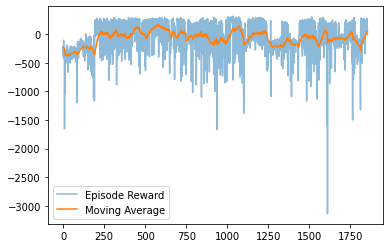

In [8]:
# Calculating EMA
prev = 0
mva = []

k = 2 / (51)

for el in episode_rewards:

    if prev != 0:
        pres = prev * (1 - k) + el * k
    else:
        pres = el 
    prev = pres
    mva.append(pres)
plt.plot(episode_rewards, alpha=0.5, label="Episode Reward")
plt.plot(mva, label="Moving Average")
plt.legend()